# CyRK - SciPy Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import njit
plt.style.use('dark_background')

import CyRK
print(CyRK.__version__)

0.15.0


### Create a differential equation to test

In [2]:
rtol = 1.0e-7
atol = 1.0e-8

use_pendulum = False
diffeq_num = 0

if use_pendulum:
    time_span = (0., 10.)
    args = (1., 1., 9.81)
    initial_conds = np.asarray((0.01, 0.), dtype=np.float64, order='C')
    diffeq_num = 6
    def diffeq(dy, t, y, l, m, g):

        # External torque
        torque = 0.1 * np.sin(t)

        y0 = y[0]  # Angular deflection [rad]
        y1 = y[1]  # Angular velocity [rad s-1]
        dy[0] = y1
        dy[1] = (-3. * g / (2. * l)) * np.sin(y0) + (3. / (m * l**2)) * torque
    
    def diffeq_scipy(t, y, l, m, g):

        # External torque
        torque = 0.1 * np.sin(t)

        y0 = y[0]  # Angular deflection [rad]
        y1 = y[1]  # Angular velocity [rad s-1]
        dy = np.empty_like(y)
        dy[0] = y1
        dy[1] = (-3. * g / (2. * l)) * np.sin(y0) + (3. / (m * l**2)) * torque
        return dy

    @njit
    def diffeq_scipy_njit(t, y, l, m, g):

        # External torque
        torque = 0.1 * np.sin(t)

        y0 = y[0]  # Angular deflection [rad]
        y1 = y[1]  # Angular velocity [rad s-1]
        dy = np.empty_like(y)
        dy[0] = y1
        dy[1] = (-3. * g / (2. * l)) * np.sin(y0) + (3. / (m * l**2)) * torque
        return dy
    
else:    
    initial_conds = np.asarray((20., 20.), dtype=np.float64)
    args = tuple()
    time_span = (0., 50.)
    def diffeq(dy, t, y):
        dy[0] = (1. - 0.01 * y[1]) * y[0]
        dy[1] = (0.02 * y[0] - 1.) * y[1]

    # Create helper function for scipy to work with this kind of diffeq
    def diffeq_scipy(t, y):

        dy = np.zeros_like(y)
        dy[0] = (1. - 0.01 * y[1]) * y[0]
        dy[1] = (0.02 * y[0] - 1.) * y[1]
        return dy
    
    @njit
    def diffeq_njit(dy, t, y):
        dy[0] = (1. - 0.01 * y[1]) * y[0]
        dy[1] = (0.02 * y[0] - 1.) * y[1]
    
    @njit
    def diffeq_scipy_njit(t, y):

        dy = np.zeros_like(y)
        dy[0] = (1. - 0.01 * y[1]) * y[0]
        dy[1] = (0.02 * y[0] - 1.) * y[1]
        return dy


# Create plotting routine
def diff_plot(t, y, fig_name=None):
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    # Show figure
    plt.show()
    
    # Save figure
    if fig_name is not None:
        fig.savefig(f'{fig_name}.pdf')

### Check results

SciPy Solution


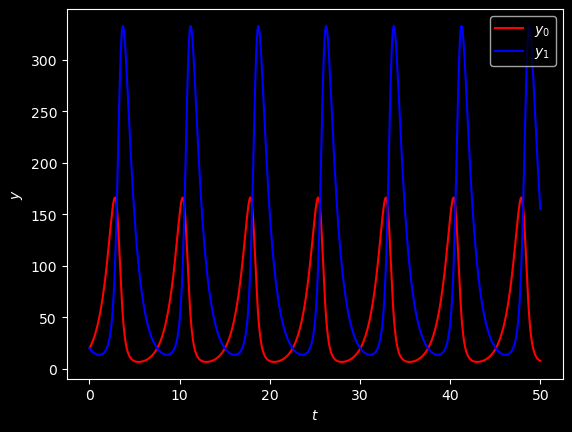

In [3]:
# Scipy
scipy_solution = solve_ivp(diffeq_scipy, time_span, initial_conds, method='RK45', args=args, rtol=rtol, atol=atol)
print('SciPy Solution')
diff_plot(scipy_solution.t, scipy_solution.y, fig_name='SciPy')

CyRK (numba) Solution


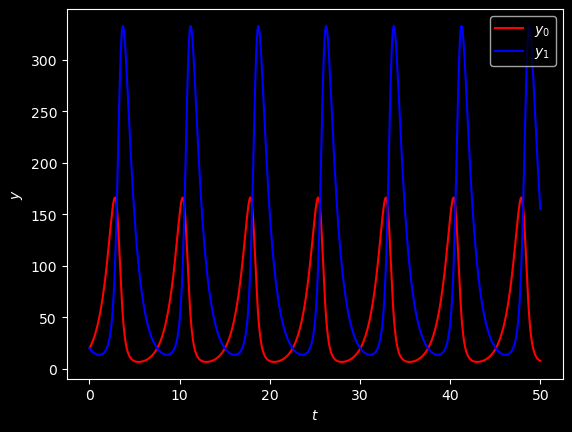

In [4]:
# CyRK - numba implementation
from CyRK import nbsolve_ivp
nb_result = \
    nbsolve_ivp(diffeq_scipy_njit, time_span, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol)
print('CyRK (numba) Solution')
diff_plot(nb_result.t, nb_result.y, fig_name='CyRK_numba')

CyRK (Cython - cysolve_ivp) Solution


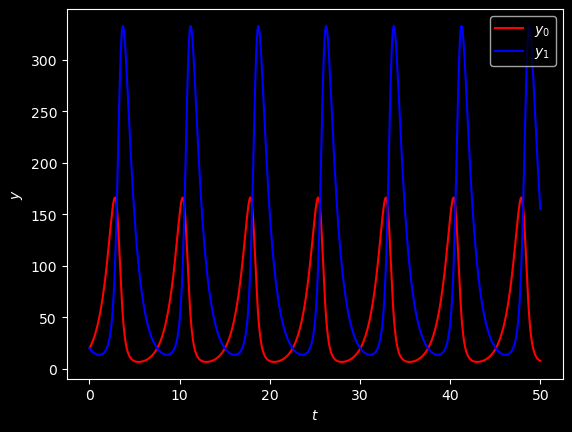

In [5]:
# CyRK - CySolver (Cython Based Solver)
from CyRK.cy.cysolver_test import cytester
cysolverNew_results = cytester(diffeq_num, time_span, initial_conds, method='rk45', rtol=rtol, atol=atol)
print('CyRK (Cython - cysolve_ivp) Solution')
diff_plot(cysolverNew_results.t, cysolverNew_results.y, fig_name='CyRK_CySolver')

CyRK (Cython - cysolve_ivp; dense on) Solution


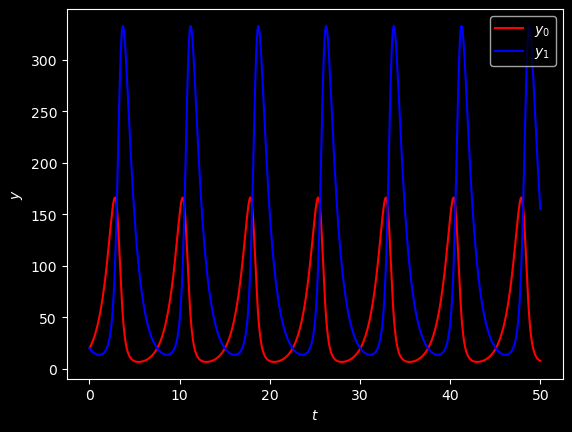

In [6]:
# CyRK - CySolver (Cython Based Solver) -- dense output on
from CyRK.cy.cysolver_test import cytester
cysolverNew_results = cytester(diffeq_num, time_span, initial_conds, method='rk45', rtol=rtol, atol=atol, dense_output=True)
print('CyRK (Cython - cysolve_ivp; dense on) Solution')
diff_plot(cysolverNew_results.t, cysolverNew_results.y, fig_name='CyRK_CySolver_DenseOn')

CyRK (pysolve_ivp) Solution


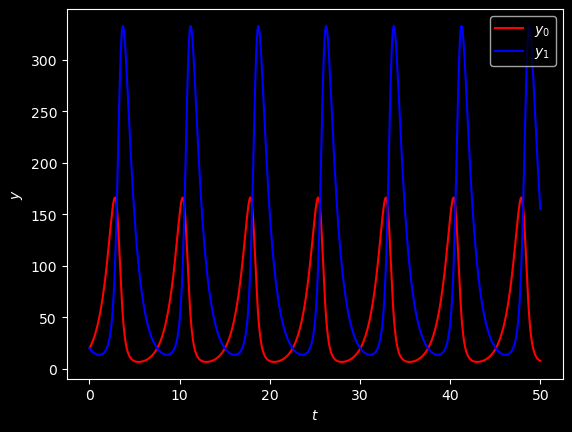

In [7]:
# CyRK - PySolver (Python based Solver)
from CyRK.cy.pysolver import pysolve_ivp
pysolver_results = pysolve_ivp(diffeq, time_span, initial_conds, method='RK45', args=args, rtol=rtol, atol=atol, pass_dy_as_arg=True)
print('CyRK (pysolve_ivp) Solution')
diff_plot(pysolver_results.t, pysolver_results.y, fig_name='CyRK_PySolver')

CyRK (pysolve_ivp with njit) Solution


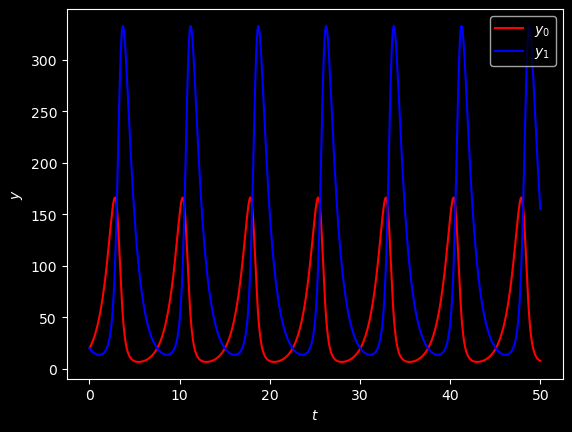

In [8]:
# CyRK - PySolver (Python based Solver) using njited function
from CyRK.cy.pysolver import pysolve_ivp
pysolver_results = pysolve_ivp(diffeq_njit, time_span, initial_conds, method='RK45', args=args, rtol=rtol, atol=atol, pass_dy_as_arg=True)
print('CyRK (pysolve_ivp with njit) Solution')
diff_plot(pysolver_results.t, pysolver_results.y, fig_name='CyRK_PySolver (njit)')

### Check Performance

In [12]:
import timeit

REPEATS = 4
print('This can take a while...\n')
# Run Results
# rtols = np.logspace(-3, -13, 11)
end_times = np.logspace(-3, 3, 7)
# end_times = np.logspace(-3, -2, 2)

methods = dict(
    scipy = solve_ivp,
    cysolve_ivp = cytester,
    pysolve_ivp = pysolve_ivp,
    pysolve_ivp_njit = pysolve_ivp,
    nbsolve_ivp = nbsolve_ivp
)

method_inputs = dict(
    scipy = ([diffeq_scipy, tuple(), initial_conds], dict(method='RK45', args=args, rtol=rtol, atol=atol, dense_output=False)),
    cysolve_ivp = ([diffeq_num, tuple(), initial_conds], dict(method='rk45', rtol=rtol, atol=atol, dense_output=False, solution_reuse=None)),
    pysolve_ivp = ([diffeq, tuple(), initial_conds], dict(method='RK45', args=args, rtol=rtol, atol=atol, pass_dy_as_arg=True, dense_output=False, solution_reuse=None)),
    pysolve_ivp_njit = ([diffeq_njit, tuple(), initial_conds], dict(method='RK45', args=args, rtol=rtol, atol=atol, pass_dy_as_arg=True, dense_output=False, solution_reuse=None)),
    nbsolve_ivp = ([diffeq_scipy_njit, tuple(), initial_conds], dict(rk_method=1, args=args, rtol=rtol, atol=atol))
)

method_colors = dict(
    scipy = ('SciPy', 'blue'),
    cysolve_ivp = ("CyRK's cysolve_ivp (Cython)", 'red'),
    pysolve_ivp = ("CyRK's pysolve_ivp (Python)", 'cyan'),
    pysolve_ivp_njit = ("CyRK's pysolve_ivp (Python + Numba)", 'orange'),
    nbsolve_ivp = ("CyRK's nbsolve_ivp (Numba)", 'green')
)

capture_dense_output = (False, True)
use_resets = (False, True)

styles = dict()
steps = dict()
times = dict()
errors = dict()

for method_name, method_func in methods.items():
    print(f'\n\nWorking on {method_name} ', end='\n')
    
    method_args, method_kwargs = method_inputs[method_name]
    for capture_dense in capture_dense_output:
        if method_name == 'nbsolve_ivp' and capture_dense:
            # Not implemented
            continue
        print(f"\tCapture Dense = {capture_dense}", end="\n")
        if capture_dense:
            method_kwargs['dense_output'] = True
        else:
            if 'dense_output' in method_kwargs:
                method_kwargs['dense_output'] = False
    
        for use_reset in use_resets:
            if method_name in ('nbsolve_ivp', 'scipy') and use_reset:
                # Not implemented
                continue
            print(f"\tUse Resets = {use_reset}", end="\n")

            if use_reset:
                method_args[1] = (0.0, 1.0)
                const_sol = method_func(*tuple(method_args), **method_kwargs)
                method_kwargs['solution_reuse'] = const_sol
            else:
                if 'solution_reuse' in method_kwargs:
                    method_kwargs['solution_reuse'] = None
            
            for end_time in end_times:
                print(f'\t\tWorking on end_time = {end_time:0.1e}.', end=" ")
                time_s = (0., end_time)
                method_args[1] = time_s

                if method_name == 'nbsolve_ivp':
                    print(f'\tNumba Pre-Compile', end=" ")
                    _ = nbsolve_ivp(diffeq_scipy_njit, time_s, initial_conds, rk_method=1, args=args, rtol=rtol, atol=atol)

                run_key = (method_name, capture_dense, use_reset)

                if run_key not in steps:
                    steps[run_key] = list()
                    times[run_key] = list()
                    errors[run_key] = list()
                    styles[run_key] = [method_colors[method_name][0], method_colors[method_name][1]]
                    # Find marker and marker size
                    if capture_dense and use_reset:
                        styles[run_key].append('2')
                        styles[run_key].append(8)
                    elif not capture_dense and use_reset:
                        styles[run_key].append('*')
                        styles[run_key].append(8)
                    elif capture_dense and not use_reset:
                        styles[run_key].append('x')
                        styles[run_key].append(8)
                    else:
                        styles[run_key].append('o')
                        styles[run_key].append(None)
                    
                timer = timeit.Timer(lambda: method_func(*tuple(method_args), **method_kwargs))
                time_list = list()
                for i in range(REPEATS):
                    N, T = timer.autorange()
                    time_list.append(T / N * 1000.)
                time_array = np.asarray(time_list)
                times[run_key].append(np.average(time_array))
                errors[run_key].append(np.std(time_array))
                _sol = method_func(*tuple(method_args), **method_kwargs)
                steps[run_key].append(_sol.t.size)
                print('... Finsihed!')
print('Done!')

This can take a while...



Working on scipy 
	Capture Dense = False
	Use Resets = False
		Working on end_time = 1.0e-03. ... Finsihed!
		Working on end_time = 1.0e-02. ... Finsihed!
		Working on end_time = 1.0e-01. ... Finsihed!
		Working on end_time = 1.0e+00. ... Finsihed!
		Working on end_time = 1.0e+01. ... Finsihed!
		Working on end_time = 1.0e+02. ... Finsihed!
		Working on end_time = 1.0e+03. ... Finsihed!
	Capture Dense = True
	Use Resets = False
		Working on end_time = 1.0e-03. ... Finsihed!
		Working on end_time = 1.0e-02. ... Finsihed!
		Working on end_time = 1.0e-01. ... Finsihed!
		Working on end_time = 1.0e+00. ... Finsihed!
		Working on end_time = 1.0e+01. ... Finsihed!
		Working on end_time = 1.0e+02. ... Finsihed!
		Working on end_time = 1.0e+03. ... Finsihed!


Working on cysolve_ivp 
	Capture Dense = False
	Use Resets = False
		Working on end_time = 1.0e-03. ... Finsihed!
		Working on end_time = 1.0e-02. ... Finsihed!
		Working on end_time = 1.0e-01. ... Finsihed!
	

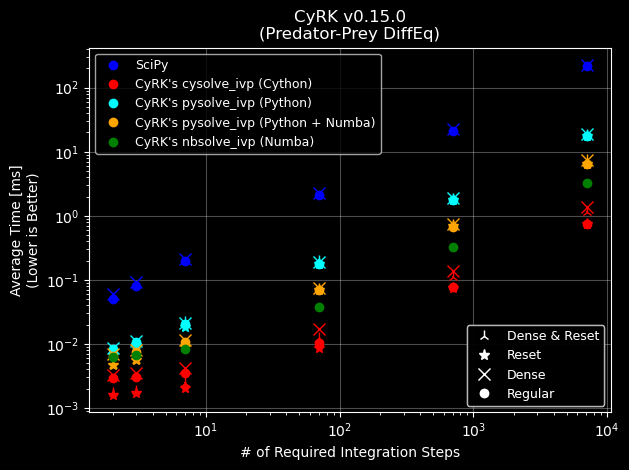

In [13]:
from CyRK import version
import matplotlib.lines as mlines

version_filesafe = version.replace('.', '-')
fig, ax = plt.subplots()
plot_vs_steps = True

color_handles_dict = dict()
type_handles = [
    mlines.Line2D([], [], color='w', marker='2', linestyle='None', markersize=8, label='Dense & Reset'),
    mlines.Line2D([], [], color='w', marker='*', linestyle='None', markersize=8, label='Reset'),
    mlines.Line2D([], [], color='w', marker='x', linestyle='None', markersize=8, label='Dense'),
    mlines.Line2D([], [], color='w', marker='o', linestyle='None', markersize=None, label='Regular')
]

for key_, style_data in styles.items():
    nice_name, color, marker, marker_size = style_data
    method_name = key_[0]
    if method_name not in color_handles_dict:
        color_handles_dict[method_name] = mlines.Line2D([], [], color=color, marker=marker, linestyle='None', markersize=marker_size, label=nice_name)
    
    step_array = np.asarray(steps[key_])
    time_array = np.asarray(times[key_])
    error_array = np.asarray(errors[key_])
    if plot_vs_steps:
        ax.errorbar(step_array[1:], time_array[1:], yerr=error_array[1:], c=color, label=nice_name, fmt=marker, markersize=marker_size)
    else:
        ax.errorbar(end_times, sci_times, yerr=error_array, c=color, label=nice_name, fmt=marker, markersize=marker_size)

if use_pendulum:
    title_name = f'CyRK v{version}\n(Pendulum DiffEq)'
else:
    title_name = f'CyRK v{version}\n(Predator-Prey DiffEq)'

if plot_vs_steps:
    ax.set(ylabel='Average Time [ms]\n(Lower is Better)', xlabel='# of Required Integration Steps', xscale='log', yscale='log')
else:
    ax.set(ylabel='Average Time [ms]\n(Lower is Better)', xlabel='Integration Domain Size', xscale='log', yscale='log')
    ax.set_xticks((1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5))
ax.grid(alpha=0.3)
# ax.set_xlim(ax.get_xlim()[::-1])

legend1 = plt.legend(handles=color_handles_dict.values(), loc='upper left', fontsize=9)
legend2 = plt.legend(handles=type_handles, loc='lower right', fontsize=9)
ax.add_artist(legend1)
ax.add_artist(legend2)

ax.set(title=title_name)
fig.tight_layout()
if use_pendulum:
    fig.savefig(f'CyRK_SciPy_Compare_pendulum_v{version_filesafe}.png')
else:
    fig.savefig(f'CyRK_SciPy_Compare_predprey_v{version_filesafe}.png')
plt.show()

In [14]:
# Print Differences
print('How much faster X is vs. Y')
for end_time, sci, nb, cysN, pys in zip(end_times,
                                        times[('scipy', False, False)],
                                        times[('nbsolve_ivp', False, False)],
                                        times[('cysolve_ivp', False, True)],
                                        times[('pysolve_ivp_njit', False, True)]):
    
    print(f'End Time: {end_time:0.1e}')
    print(f'\t nbsolve_ivp = {sci / nb:5.2f}x SciPy', end='')
    print(f'\t nbsolve_ivp = {cysN / nb:5.2f}x cysolve_ivp', end='\n')
    print(f'\t pysolve_ivp = { sci / pys:5.2f}x SciPy', end='')
    print(f'\t pysolve_ivp = { cysN / pys:5.2f}x cysolve_ivp', end='\n')
    print(f'\t cysolve_ivp = { sci / cysN:5.2f}x SciPy', end='')
    print(f'\t cysolve_ivp = { pys / cysN:5.2f}x pysolve_ivp', end='\n')

How much faster X is vs. Y
End Time: 1.0e-03
	 nbsolve_ivp =  8.03x SciPy	 nbsolve_ivp =  0.24x cysolve_ivp
	 pysolve_ivp = 11.10x SciPy	 pysolve_ivp =  0.34x cysolve_ivp
	 cysolve_ivp = 32.82x SciPy	 cysolve_ivp =  2.96x pysolve_ivp
End Time: 1.0e-02
	 nbsolve_ivp =  8.04x SciPy	 nbsolve_ivp =  0.25x cysolve_ivp
	 pysolve_ivp = 10.93x SciPy	 pysolve_ivp =  0.34x cysolve_ivp
	 cysolve_ivp = 32.23x SciPy	 cysolve_ivp =  2.95x pysolve_ivp
End Time: 1.0e-01
	 nbsolve_ivp = 11.74x SciPy	 nbsolve_ivp =  0.25x cysolve_ivp
	 pysolve_ivp = 14.47x SciPy	 pysolve_ivp =  0.31x cysolve_ivp
	 cysolve_ivp = 47.28x SciPy	 cysolve_ivp =  3.27x pysolve_ivp
End Time: 1.0e+00
	 nbsolve_ivp = 23.24x SciPy	 nbsolve_ivp =  0.24x cysolve_ivp
	 pysolve_ivp = 21.76x SciPy	 pysolve_ivp =  0.23x cysolve_ivp
	 cysolve_ivp = 95.93x SciPy	 cysolve_ivp =  4.41x pysolve_ivp
End Time: 1.0e+01
	 nbsolve_ivp = 57.42x SciPy	 nbsolve_ivp =  0.23x cysolve_ivp
	 pysolve_ivp = 30.71x SciPy	 pysolve_ivp =  0.13x cysolve_ivp
	